In [5]:
from langchain_core.messages import HumanMessage , SystemMessage , AIMessage

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY']=os.getenv("OPENAI_API_KEY")


In [38]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-4.1-nano-2025-04-14")

In [8]:
llm.invoke("hello who are you")

AIMessage(content='Hi! I’m an AI assistant. I can help answer questions, brainstorm ideas, explain concepts, draft text, summarize articles, code, and assist with many other tasks. How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 10, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D8pV7yIqf16z9dF17bPp8tb6EOkSL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c57a5-1c2d-7732-9d66-bca92575299d-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 10, 'output_tokens': 51, 'total_tokens': 61, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_tok

In [9]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([("system","you have been give job description and skills find the requiremnts that are missing in the skills compared to jobdescription "),
                                           ("human","""here is the job description :
  <job decription>
  {jobDescription}
  </jobDescription>
  find the gaps for the given skills :
  <skills>\n{skills}\n</skills>\n """)
  ])

In [10]:
jsonSchema = {
  "$schema": "https://json-schema.org/draft/2020-12/schema",
  "title": "ResumeJobGapAnalysis",
  "type": "object",
  "additionalProperties": {"type":"boolean"},

  "required": [
    "analysis_status",
    "missing",
    "irrelevant_or_less_relevant",
    "experience_gap",
    "summary"
  ],

  "properties": {
    "analysis_status": {
      "type": "string",
      "enum": ["success", "failure"],
      "description": "Indicates whether the gap analysis was completed successfully."
    },

    "missing": {
      "type": "array",
      "items": { "type": "string" },
      "description": "All missing skills, tools, platforms, and concepts required by the job description but not present in the resume."
    },

    "irrelevant_or_less_relevant": {
      "type": "array",
      "items": { "type": "string" },
      "description": "All skills or experience present in the resume but not required or less relevant for this job."
    },

    "experience_gap": {
      "type": "array",
      "items": { "type": "string" },
      "description": "Experience-related gaps, including required vs actual experience differences."
    },

    "summary": {
      "type": "string",
      "description": "Concise summary of the main gaps between the resume and job description."
    }
  }
}


In [11]:
llmWithSchema = llm.with_structured_output(jsonSchema)
chain = prompt | llmWithSchema

In [12]:
jobDescription = """Job Title: Backend Software Engineer

We are looking for a Backend Software Engineer to design, develop, and maintain scalable server-side applications.

Responsibilities:
- Design and implement RESTful APIs using Python and Flask.
- Build and maintain database schemas and queries using MySQL.
- Optimize application performance and ensure high availability.
- Write clean, maintainable, and well-tested code.
- Collaborate with frontend developers and product managers.
- Participate in code reviews and technical discussions.

Requirements:
- Strong proficiency in Python.
- Experience with Flask or similar web frameworks.
- Good understanding of relational databases, especially MySQL.
- Knowledge of RESTful API design principles.
- Familiarity with Git and version control workflows.
- Basic understanding of cloud platforms (AWS or GCP preferred).

Experience & Education:
- 2–4 years of professional backend development experience.
- Bachelor’s degree in Computer Science or related field.

Preferred Qualifications:
- Experience with Docker and containerization.
- Knowledge of CI/CD pipelines.
- Familiarity with microservices architecture.
"""

skills = """Skills:
- Python
- Java
- Basic Flask
- HTML, CSS, JavaScript
- SQLite
- Git

Experience:
- 1 year experience building small web applications using Flask.
- Built REST APIs for a college project.
- Worked on frontend development using HTML and JavaScript.

Education:
- Bachelor’s degree in Information Technology

Tools:
- Git, GitHub
- VS Code
"""

In [13]:
prompt.invoke({"jobDescription":jobDescription , "skills":skills})

ChatPromptValue(messages=[SystemMessage(content='you have been give job description and skills find the requiremnts that are missing in the skills compared to jobdescription ', additional_kwargs={}, response_metadata={}), HumanMessage(content='here is the job description :\n  <job decription>\n  Job Title: Backend Software Engineer\n\nWe are looking for a Backend Software Engineer to design, develop, and maintain scalable server-side applications.\n\nResponsibilities:\n- Design and implement RESTful APIs using Python and Flask.\n- Build and maintain database schemas and queries using MySQL.\n- Optimize application performance and ensure high availability.\n- Write clean, maintainable, and well-tested code.\n- Collaborate with frontend developers and product managers.\n- Participate in code reviews and technical discussions.\n\nRequirements:\n- Strong proficiency in Python.\n- Experience with Flask or similar web frameworks.\n- Good understanding of relational databases, especially MySQ

In [14]:
gaps = chain.invoke({"jobDescription":jobDescription , "skills":skills})

In [15]:
print(gaps)

{'type': 'object', 'properties': {'analysis_status': {'type': 'string', 'enum': ['success', 'failure'], 'description': 'Indicates whether the gap analysis was completed successfully.'}, 'missing': {'type': 'array', 'items': {'type': 'string'}, 'description': 'All missing skills, tools, platforms, and concepts required by the job description but not present in the resume.'}, 'irrelevant_or_less_relevant': {'type': 'array', 'items': {'type': 'string'}, 'description': 'All skills or experience present in the resume but not required or less relevant for this job.'}, 'experience_gap': {'type': 'array', 'items': {'type': 'string'}, 'description': 'Experience-related gaps, including required vs actual experience differences.'}, 'summary': {'type': 'string', 'description': 'Concise summary of the main gaps between the resume and job description.'}}, 'required': ['analysis_status', 'missing', 'irrelevant_or_less_relevant', 'experience_gap', 'summary']}


### filling Gaps

In [16]:
skillsToAdd = list()
resume_specific = list()
ignore = list()
for keys in gaps.keys():
    print("""Options:
1) Add the skill you forgot to specify (you know this skill). Please provide the exact phrasing to put on the resume.
2) Just add the skill for resume generation (a generic label, no extra detail).
3) Ignore the skill (leave as is, do not add).""")
    if( type(gaps[keys]) == list ):
        for key in gaps[keys]:
            print(key)
            value = key 
            n = int(input("enter value:"))
    else:
        print(gaps[keys])
        value = gaps[keys]
        n = int(input("enter value:"))
    
    if( n == 1 ):
        skillsToAdd.append(value)
    elif ( n == 2):
        resume_specific.append(value)
    elif( n== 3 ):
        ignore.append(value)
    else:
        print("not there")


Options:
1) Add the skill you forgot to specify (you know this skill). Please provide the exact phrasing to put on the resume.
2) Just add the skill for resume generation (a generic label, no extra detail).
3) Ignore the skill (leave as is, do not add).
object


ValueError: invalid literal for int() with base 10: ''

### FAil
1

In [ ]:
from typing_extensions import TypedDict
from typing import List
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
class State (TypedDict):
    # gaps : str
    # skills : List[str]
    # resume_specific : List[str]
    # ignore :List[str] 
    messages:Annotated[list,add_messages]

In [ ]:
# def handOveringGaps(state:State):
#     questioningPrompt = ChatPromptTemplate.from_messages([
#     ("system","""your task is to ask the user where he want to , 
#     1.add skill which he for got to specify in  resume and he knows that skill .
#     2.just add the skill for the resume genartion .
#     3.ignore the skill.
#     make sure he specifies correctly or else ask again
#     keep asking until all gaps are specified with their respective feild
#     """),
#     ("human","here is the skills that are missing {gaps}")
#     ])
#     return {"messages":questioningPrompt.invoke({"gaps":state["gaps"]}).messages}

In [ ]:
# handOveringGaps({"gaps": str(gaps) , "messages":HumanMessage(content="") })

In [ ]:
def llm_calling(state:State):
    print(state["messages"])
    result = llm.invoke(state["messages"])
    return {"messages":state["messages"] + [result]}

In [ ]:
questioningPrompt = ChatPromptTemplate.from_messages([
    ("system","""your task is to ask the user where he want to , 
    1.add skill which he for got to specify in  resume and he knows that skill .
    2.just add the skill for the resume genartion .
    3.ignore the skill.
    make sure he specifies correctly or else ask again
    keep asking until all gaps are specified with their respective feild
    ask one by one
    """),
    ("human","here is the skills that are missing {gaps}")
    ])
llm_calling({"messages":questioningPrompt.invoke({"gaps":str(gaps)}).messages })

[SystemMessage(content='your task is to ask the user where he want to , \n    1.add skill which he for got to specify in  resume and he knows that skill .\n    2.just add the skill for the resume genartion .\n    3.ignore the skill.\n    make sure he specifies correctly or else ask again\n    keep asking until all gaps are specified with their respective feild\n    ask one by one\n    ', additional_kwargs={}, response_metadata={}), HumanMessage(content="here is the skills that are missing {'analysis_status': 'success', 'missing': ['MySQL database experience (beyond basic relational databases)', 'RESTful API design principles (explicit emphasis beyond building APIs)', 'Cloud platforms familiarity (AWS or GCP)', 'Docker and containerization', 'CI/CD pipelines', 'Microservices architecture knowledge', '2–4 years of professional backend development experience', 'Bachelor’s degree in Computer Science or a related field (the resume shows Information Technology)', 'Experience with relational 

{'messages': [SystemMessage(content='your task is to ask the user where he want to , \n    1.add skill which he for got to specify in  resume and he knows that skill .\n    2.just add the skill for the resume genartion .\n    3.ignore the skill.\n    make sure he specifies correctly or else ask again\n    keep asking until all gaps are specified with their respective feild\n    ask one by one\n    ', additional_kwargs={}, response_metadata={}),
  HumanMessage(content="here is the skills that are missing {'analysis_status': 'success', 'missing': ['MySQL database experience (beyond basic relational databases)', 'RESTful API design principles (explicit emphasis beyond building APIs)', 'Cloud platforms familiarity (AWS or GCP)', 'Docker and containerization', 'CI/CD pipelines', 'Microservices architecture knowledge', '2–4 years of professional backend development experience', 'Bachelor’s degree in Computer Science or a related field (the resume shows Information Technology)', 'Experience w

In [ ]:
conditionEdge_schema = {
  "$schema": "https://json-schema.org/draft/2020-12/schema",
  "title": "FlowControlDecision",
  "type": "object",
  "additionalProperties": {"type":"boolean"},

  "required": [
    "status"
  ],

  "properties": {
    "status": {
      "type": "string",
      "enum": ["continue", "__end__"],
      "description": "Decision to either continue asking or end it."
    }
  }
}
llm.with_structured_output(conditionEdge_schema).invoke("its over")

{'status': '__end__'}

In [ ]:
from langgraph.prebuilt import tools_condition

def conditionEdge(state:State):
    conditionEdge_schema = {
  "$schema": "https://json-schema.org/draft/2020-12/schema",
  "title": "FlowControlDecision",
  "type": "object",
  "additionalProperties": {"type":"boolean"},

  "required": [
    "status"
  ],

  "properties": {
    "status": {
      "type": "string",
      "enum": ["continue", "__end__"],
      "description": "Decision to either continue asking or end it."
    }
  }
}
    result = llm.with_structured_output(conditionEdge_schema).invoke(state["messages"])
    return result["status"]


In [ ]:
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import MemorySaver
graph_builder = StateGraph(State)

# graph_builder.add_node( "handOveringGaps",handOveringGaps)
graph_builder.add_node("llm_calling",llm_calling)

# graph_builder.add_edge(START , "handOveringGaps")
graph_builder.add_edge(START,"llm_calling")
graph_builder.add_conditional_edges("llm_calling",conditionEdge,{"continue":"llm_calling","__end__":END})

memory=MemorySaver()
graph = graph_builder.compile(interrupt_after= ["llm_calling" ],checkpointer= memory)


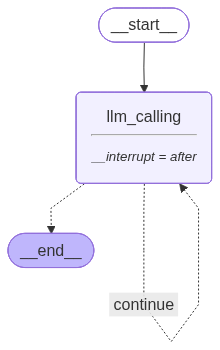

In [ ]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
thread={"configurable":{"thread_id":"123"}}
questioningPrompt = ChatPromptTemplate.from_messages([
    ("system","""your task is to ask the user where he want to , 
    1.add skill which he for got to specify in  resume and he knows that skill .
    2.just add the skill for the resume genartion .
    3.ignore the skill.
    make sure he specifies correctly or else ask again
    keep asking until all gaps are specified with their respective feild
    """),
    ("human","here is the skills that are missing {gaps}")
    ])
initial_input={"messages":questioningPrompt.invoke({"gaps":str(gaps)}).messages}

In [ ]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

restful api choice 2
[SystemMessage(content='your task is to ask the user where he want to , \n    1.add skill which he for got to specify in  resume and he knows that skill .\n    2.just add the skill for the resume genartion .\n    3.ignore the skill.\n    make sure he specifies correctly or else ask again\n    keep asking until all gaps are specified with their respective feild\n    ', additional_kwargs={}, response_metadata={}, id='4be5a489-bc3e-4dd0-be13-ab0fa67d35e5'), HumanMessage(content="here is the skills that are missing {'analysis_status': 'success', 'missing': ['MySQL database experience (beyond basic relational databases)', 'RESTful API design principles (explicit emphasis beyond building APIs)', 'Cloud platforms familiarity (AWS or GCP)', 'Docker and containerization', 'CI/CD pipelines', 'Microservices architecture knowledge', '2–4 years of professional backend development experience', 'Bac

In [ ]:
state=graph.get_state(thread)
state.next

('llm_calling',)

In [ ]:
for message in state.values["messages"]:
    message.pretty_print()

================================ System Message ================================

your task is to ask the user where he want to , 
    1.add skill which he for got to specify in  resume and he knows that skill .
    2.just add the skill for the resume genartion .
    3.ignore the skill.
    make sure he specifies correctly or else ask again
    keep asking until all gaps are specified with their respective feild
    
================================ Human Message =================================

here is the skills that are missing {'analysis_status': 'success', 'missing': ['MySQL database experience (beyond basic relational databases)', 'RESTful API design principles (explicit emphasis beyond building APIs)', 'Cloud platforms familiarity (AWS or GCP)', 'Docker and containerization', 'CI/CD pipelines', 'Microservices architecture knowledge', '2–4 years of professional backend development experience', 'Bachelor’s degree in Computer Science or a related field (the resume shows Informati

In [ ]:
initial_input={"messages":HumanMessage(content=input("enter something:"))}
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

make odd serial number ones choice 2
[SystemMessage(content='your task is to ask the user where he want to , \n    1.add skill which he for got to specify in  resume and he knows that skill .\n    2.just add the skill for the resume genartion .\n    3.ignore the skill.\n    make sure he specifies correctly or else ask again\n    keep asking until all gaps are specified with their respective feild\n    ', additional_kwargs={}, response_metadata={}, id='4be5a489-bc3e-4dd0-be13-ab0fa67d35e5'), HumanMessage(content="here is the skills that are missing {'analysis_status': 'success', 'missing': ['MySQL database experience (beyond basic relational databases)', 'RESTful API design principles (explicit emphasis beyond building APIs)', 'Cloud platforms familiarity (AWS or GCP)', 'Docker and containerization', 'CI/CD pipelines', 'Microservices architecture knowledge', '2–4 years of professional backend development e

### Generation

In [ ]:
result = llm.invoke(f"""
                    write in latexcode
You are a professional resume generation agent.

Generate a tailored resume using the structured inputs below.

<job_description>
{jobDescription}
</job_description>

<user_original_skills>
{skills}
</user_original_skills>

<skills_to_add_confirmed_by_user>
{skillsToAdd}
</skills_to_add_confirmed_by_user>

<resume_specific_points>
{resume_specific}
</resume_specific_points>

<ignore>
{ignore}
</ignore>

Instructions:

1. Skills Handling:
   - The Skills section must start from <user_original_skills>.
   - Add all skills from <skills_to_add_confirmed_by_user> into the Skills section.
   - Do NOT remove or overwrite any original user skills.
   - Clearly merge both lists into a single clean Skills section.

2. Resume Generation:
   - Align the resume closely with <job_description>.
   - Emphasize the points in <resume_specific_points>.
   - Do NOT include anything mentioned in <ignore>.
   - Do NOT fabricate companies, projects, dates, or experiences not implied by inputs.

3. Structure:
   Generate the resume in the following sections only:
   - Summary
   - Skills
   - Experience
   - Projects
   - Education

Output Rules:
- Output only the resume text.
- No explanations, no metadata, no commentary.
"""
)

In [ ]:
print(result.content)

NameError: name 'result' is not defined

In [45]:
string = r"""
\documentclass{article}
\begin{document}

{\fontsize{14pt}{16pt}\selectfont This is a single line of text.}

\end{document}
"""

In [ ]:
def Edit(oldString: str, newString: str) -> str:
    """
    Replaces all occurrences of oldString with newString in the given text.

    Parameters:
    -----------
    oldString : str
        The substring that needs to be replaced.
    newString : str
        The substring that will replace oldString.

    Returns:
    --------
    str
        The updated string after performing the replacement.

    Example:
    --------
    >>> Edit("hello", "hi", "hello world")
    'hi world'
    """
    return text.replace(oldString, newString)

In [40]:
llm_with_tools = llm.bind_tools([Edit])

In [ ]:
llm_with_tools.invoke([HumanMessage(content =  r"""
\documentclass{article}
\begin{document}

{\fontsize{14pt}{16pt}\selectfont This is   a single line of text.}

\end{document}
"""),HumanMessage(content = "change the font to 11pt instead of 14pt")]).tool_calls

[{'name': 'Edit',
  'args': {'oldString': '\\fontsize{14pt}{16pt}\\selectfont',
   'newString': '\\fontsize{11pt}{13pt}\\selectfont',
   'text': '\\documentclass{article}\n\\begin{document}\n\n{\\fontsize{14pt}{16pt}\\selectfont This is a single line of text.}\n\n\\end{document}'},
  'id': 'call_hFkdDE1GIY2YyHGBEIKgP8Y1',
  'type': 'tool_call'}]

In [33]:
string = string.replace("\documentclass[11pt]","\documentclass[12pt]")

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2291/1281716782.py:1: SyntaxWarning: invalid escape sequence '\d'
  string = string.replace("\documentclass[11pt]","\documentclass[12pt]")
/tmp/ipykernel_2291/1281716782.py:1: SyntaxWarning: invalid escape sequence '\d'
  string = string.replace("\documentclass[11pt]","\documentclass[12pt]")


In [34]:
print(string)

\documentclass[12pt]
\section*{Summary
Results-driven Backend Software Engineer with strong expertise in Python and RESTful API development. Proficient in designing scalable server-side solutions, building robust MySQL schemas, and delivering clean, well-tested code. Experienced collaborating with frontend developers, product managers, and cross-functional teams to ship reliable backend services. Familiar with Git workflows and basic cloud concepts, focused on delivering production-grade backend features with emphasis on performance and high availability.

\section
- Experience with relational databases in production-grade environments (beyond SQLite) \ - The resume partially matches the backend role (strong Python and basic Flask, REST API basics, Git). Gaps exist in database alignment (MySQL vs SQLite), explicit REST design principles, cloud/platform experience (AWS/GCP), containerization (Docker), CI/CD, microservices, and overall 2–4 years of backend experience. Additionally, the e